# Exercise 1

study the binomial inference for a study that reports y = 7 successes in n = 20 independent trial.
Assume the following priors:
- a uniform distribution
- a Jeffrey’s prior
- a step function:
g(π) = π if π ≤ 0.2, 0.2 if 0.2 < π ≤ 0.3, 0.5 − π if 0.3 < π ≤ 0.5, 0 if 0.5 < π

In [1]:
# successes and trials
y <- 7
n <- 20

# define the prior density functions
unif = function(p){dbeta(p, 1, 1)}
jeff = function(p){dbeta(p, 0.5, 0.5)}
step = function(p){ifelse(p <= 0.2 & p >= 0,   p,
                   ifelse(p > 0.2  & p <= 0.3, 0.2,
                   ifelse(p > 0.3  & p <= 0.5, 0.5 - p, 
                                               0)))}

# define the likelihood function                # normalise
likelihood = function(p, y, n){
    
    norm <- integrate(function(x) dbinom(y, n, x), lower = 0, upper = 1)[[1]]
    return (dbinom(y, n, p) / norm)
}

# define the posterior density function
dpost = function(prior){ function(p, y, n){
    
    # normalise
    likelihood(p, y, n) * prior(p) / integrate(function(x) likelihood(x, y, n) * prior(x), lower = 0, upper = 1)[[1]]
}}

# define the posterior cumulative density function
ppost = function(prior){ function(upper, y, n){
    
    # let's define the function so that 'upper' can be a vector. This is needed to plot it
    values <- c()
    for (i in 1:length(upper)){
                                                                               
            values <- append(values, integrate(function(x) dpost(prior)(x,y,n), lower=0, upper=upper[i])[[1]])
    }
    return (values)
}}
                                              
# define the quantile function (inverse of cumulative)
qpost = function(prior){ function(quant, y, n){
    
    # let's define the function so that 'upper' can be a vector. This is needed to plot it
    values <- c()
    for (i in 1:length(quant)){
                                                                                      
            values <- append(values, uniroot(function(x, z) ppost(prior)(x,y,n) - z, 
                                            interval = c(10^-12, 1), z = quant[i])$root)# extremely small offset for
                                                                                        # integration intervals to avoid
                                                                                        # problems of divergence
                                                                                        # cannot look for quantile smaller
                                                                                        # than this!
    }
    return (values)
}}

- plot the posterior distribution and summerize the results computing the first two moments
- compute a 95% credibility interval and give the results in a summary table
- draw the limits on the plot of the posterior distribution

Prior,Mean,SecondMoment,CredibilityLimitInf,CredibilityLimitSup
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Uniform,0.3636364,0.1422925,0.1810694,0.5696854
Jeffrey,0.3571429,0.1379870,0.1722765,0.5677829
Step function,0.3120458,0.1023703,0.1751867,0.4474527


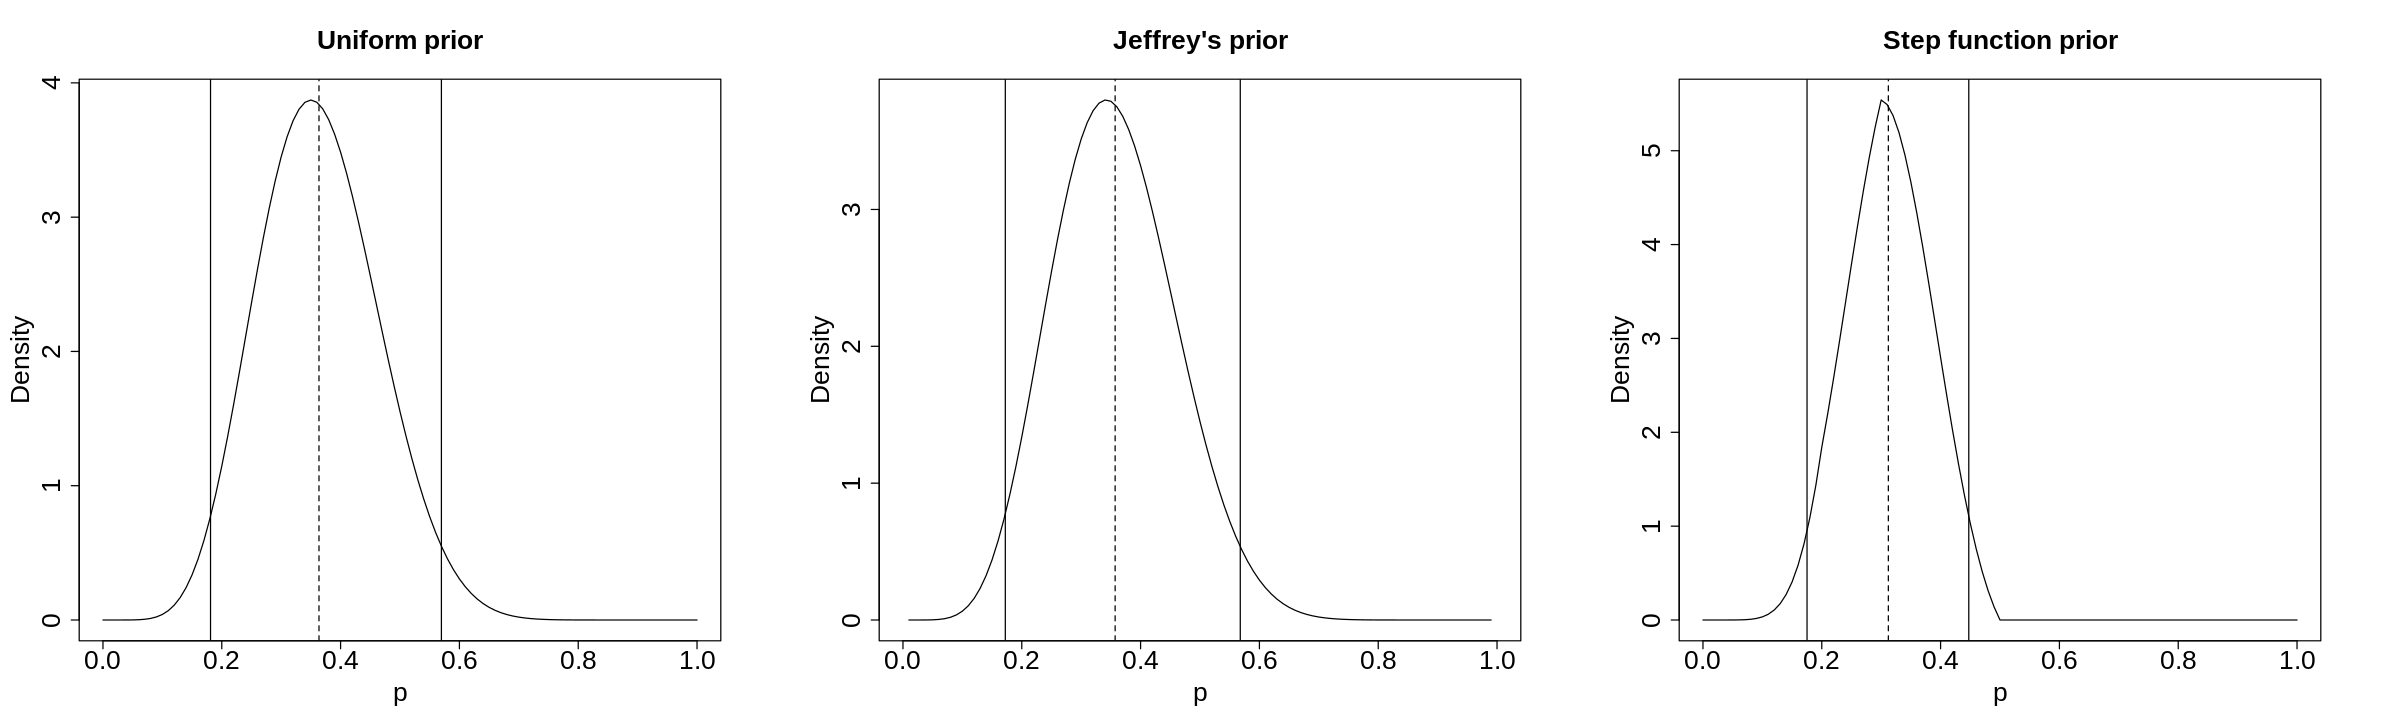

In [2]:
# compute first two moments
mean <- c()
mean <- append(mean, integrate(function(x) x * dpost(unif)(x,y,n), lower=0, upper=1)[[1]])
mean <- append(mean, integrate(function(x) x * dpost(jeff)(x,y,n), lower=0, upper=1)[[1]])
mean <- append(mean, integrate(function(x) x * dpost(step)(x,y,n), lower=0, upper=1)[[1]])
                              
sec.mom <- c()
sec.mom <- append(sec.mom, integrate(function(x) x^2 * dpost(unif)(x,y,n), lower=0, upper=1)[[1]])
sec.mom <- append(sec.mom, integrate(function(x) x^2 * dpost(jeff)(x,y,n), lower=0, upper=1)[[1]])
sec.mom <- append(sec.mom, integrate(function(x) x^2 * dpost(step)(x,y,n), lower=0, upper=1)[[1]])
                                    
# compute the credibility intervals
cred.limits <- c(0.025, 0.975)
crint <- c()
crint <- append(crint, qpost(unif)(cred.limits,y,n))
crint <- append(crint, qpost(jeff)(cred.limits,y,n))
crint <- append(crint, qpost(step)(cred.limits,y,n))
                                    
# summarise the results in a dataframe
results <- data.frame(Prior = c('Uniform', 'Jeffrey', 'Step function'),
                     Mean  = mean,
                     SecondMoment = sec.mom,
                     CredibilityLimitInf = crint[c(1,3,5)],
                     CredibilityLimitSup = crint[c(2,4,6)])

                                                                        
# plot the posterior distribution
options(repr.plot.width=20, repr.plot.height=6)
# set the #columns, title size, axis label size, tick label size, margins within plots
par(mfrow = c(1, 3), cex.main = 2, cex.lab = 2, cex.axis = 2, mar = c(5, 5, 5, 5))
                                    
curve(dpost(unif)(x, y, n), from = 0, to = 1, main = "Uniform prior", xlab = "p", ylab = "Density")
abline(v=mean[1], lty=2)
abline(v=crint[1])
abline(v=crint[2])
                                    
curve(dpost(jeff)(x, y, n), from = 0, to = 1, main = "Jeffrey's prior", xlab = "p", ylab = "Density")
abline(v=mean[2], lty=2)
abline(v=crint[3])
abline(v=crint[4])
                                    
curve(dpost(step)(x, y, n), from = 0, to = 1, main = "Step function prior", xlab = "p", ylab = "Density")
abline(v=mean[3], lty=2)
abline(v=crint[5])
abline(v=crint[6])
                                    
results

Loading required namespace: ggplot2



mean,lower,upper
<dbl>,<dbl>,<dbl>
0.3636364,0.1733907,0.5605554
0.3571429,0.1639116,0.5576932


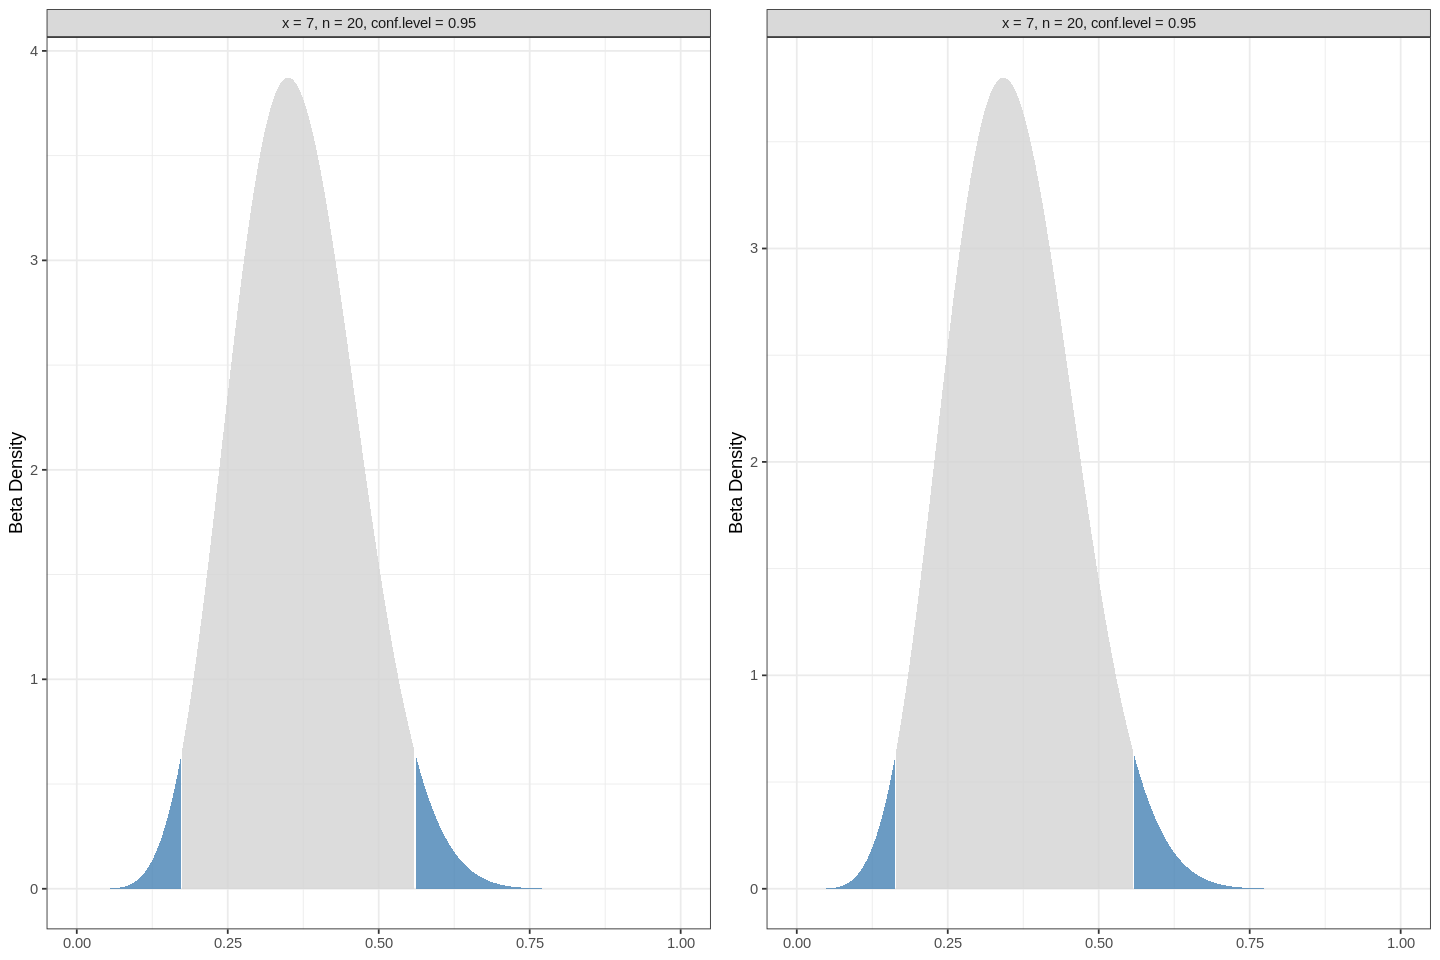

In [3]:
# Here we repeat the analysis employing the package 'binom', which is very powerful since it gives all that is required
# automatically, but with the disadvantage of taking as prior only Beta functions (the step function cannot be used)

library(binom)
library(gridExtra, warn.conflicts=FALSE)

# Define the data
x <- as.numeric("7")
n <- as.numeric("20")

# uniform prior: Beta(1, 1)
unif <- binom.bayes(x = x, n = n, conf.level = 0.95, prior.shape1=1, prior.shape2=1)

# Jeffrey's prior: Beta(0.5, 0.5)
jeff <- binom.bayes(x = x, n = n, conf.level = 0.95, prior.shape1=0.5, prior.shape2=0.5)

# print information
mean  <- c(unif$mean, jeff$mean)
lower <- c(unif$lower, jeff$lower)
upper <- c(unif$upper, jeff$upper)

df <- data.frame(mean = mean, lower = lower, upper = upper)

# plot
options(repr.plot.width=12, repr.plot.height=8)
grid.arrange(binom.bayes.densityplot(unif), binom.bayes.densityplot(jeff), ncol=2)

df

# Exercise 2

Giardia cysts[1] is a parassite that can contaminate food, water, and surfaces, and they can cause
giardiasis when swallowed in this infective stage of their life cycle. Infection occurs when a person
swallows Giardia cysts from contaminated water, food, hands, surfaces, or objects.
A group of researchers, working for a Human Health Department, work for determining the quality
of stream water.
They take n = 116 samples of one-liter water from sites identified to have a heavy environmental
impact from birds and waterflow.
Out of these samples, y = 17 samples contained Giard cystis.

- Assuming π as the probability that one-liter water sample contains Giardia cystis, find the posterior distribution for π
    - assuming a uniform prior distribution
    - assuming a Beta (1, 4) prior

- Plot the posterior distribution and summerize the results computing the first two moments
- find a normal approximation for the posterior g

π


 y

- compute a 95% credibility interval both for the original posterior and for the normal approximation,
giving the results in a summary table
- add the limits on the plot of the posterior distributions

In [4]:
# define a function to compute the sigma of the distributions
sigma = function(r, n, alpha, beta){sqrt((r + alpha - 1) * (n - r + beta - 1) / (n + alpha + beta - 2)^3)}

In [5]:
n <- 116
y <- 17

# we can use the functions already implemented in the previous point
# we just have to add the beta prior:
unif = function(p){dbeta(p, 1, 1)}
beta14 = function(p){dbeta(p, 1, 4)}

# compute first two moments
mean <- c()
mean <- append(mean, integrate(function(x) x * dpost(unif)(x,y,n), lower=0, upper=1)[[1]])
mean <- append(mean, integrate(function(x) x * dpost(beta14)(x,y,n), lower=0, upper=1)[[1]])
                              
sec.mom <- c()
sec.mom <- append(sec.mom, integrate(function(x) x^2 * dpost(unif)(x,y,n), lower=0, upper=1)[[1]])
sec.mom <- append(sec.mom, integrate(function(x) x^2 * dpost(beta14)(x,y,n), lower=0, upper=1)[[1]])

In [6]:
# Normal approximation:
# (1) compute the probabilities corresponding to the maxima
argmax <- c()
argmax <- append(argmax, optimise(function(x) dpost(unif)(x,y,n), interval = c(0, 1), maximum = TRUE)$maximum)
argmax <- append(argmax, optimise(function(x) dpost(beta14)(x,y,n), interval = c(0, 1), maximum = TRUE)$maximum)

# (2) compute the sigmas
sig <- c()
sig <- append(sig, sigma(y,n,1,1))
sig <- append(sig, sigma(y,n,1,4))
                           
# compute the credibility intervals for the gaussian functions
cred.limits <- c(0.025, 0.975)
crint.gauss <- c()
crint.gauss <- append(crint.gauss, qnorm(cred.limits, mean = argmax[1], sd = sig[1]))
crint.gauss <- append(crint.gauss, qnorm(cred.limits, mean = argmax[2], sd = sig[2]))

Prior,Mean,SecondMoment,CredibilityLimitInf,CredibilityLimitSup,GaussLimitInf,GaussLimitSup
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Uniform,0.1525424,0.02435550,0.09377355,0.2224058,0.08219170,0.2109079
"Beta(1,4)",0.1487603,0.02316759,0.09138989,0.2171086,0.07998562,0.2057282


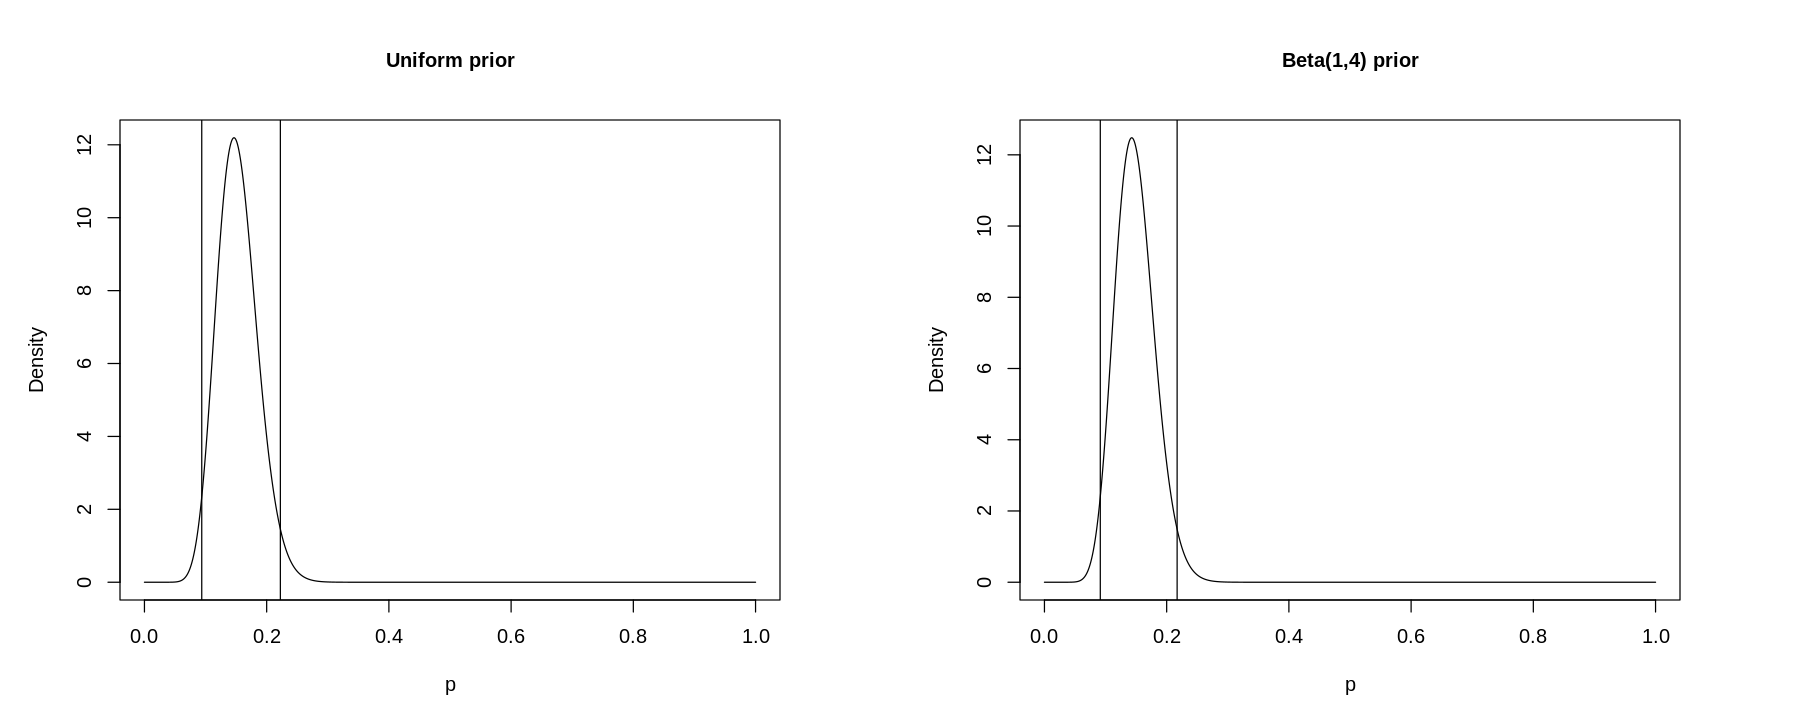

In [7]:
# compute the credibility intervals
crint <- c()
crint <- append(crint, qpost(unif)(cred.limits,y,n))
crint <- append(crint, qpost(beta14)(cred.limits,y,n))
                                    
# summarise the results in a dataframe
results <- data.frame(Prior = c('Uniform', 'Beta(1,4)'),
                     Mean  = mean,
                     SecondMoment = sec.mom,
                     CredibilityLimitInf = crint[c(1,3)],
                     CredibilityLimitSup = crint[c(2,4)],
                     GaussLimitInf = crint.gauss[c(1,3)],
                     GaussLimitSup = crint.gauss[c(2,4)])

                                                                        
# plot the posterior distribution
options(repr.plot.width=15, repr.plot.height=6)
# set the #columns, title size, axis label size, tick label size, margins within plots
par(mfrow = c(1, 2), cex.main = 1, cex.lab = 1, cex.axis = 1, mar = c(5, 5, 5, 5))

curve(dpost(unif)(x, y, n), from = 0, to = 1, main = "Uniform prior", xlab = "p", ylab = "Density", n = 10^4)
abline(v=crint[1])
abline(v=crint[2])
                                    
curve(dpost(beta14)(x, y, n), from = 0, to = 1, main = "Beta(1,4) prior", xlab = "p", ylab = "Density", n = 10^4)
abline(v=crint[3])
abline(v=crint[4])
                                    
results

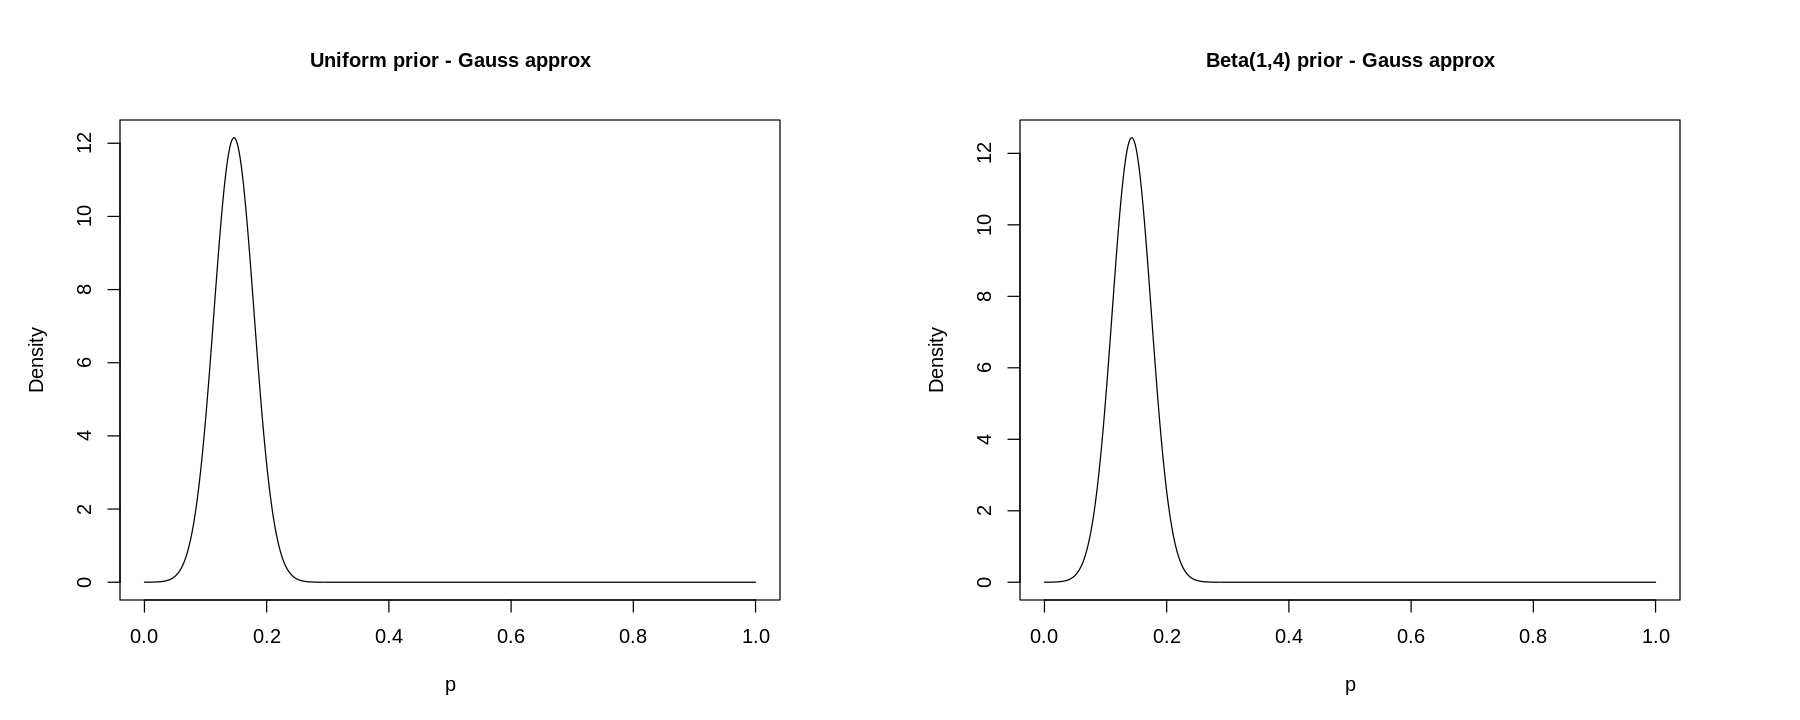

In [8]:
# plot gaussian approximations
par(mfrow = c(1, 2), cex.main = 1, cex.lab = 1, cex.axis = 1, mar = c(5, 5, 5, 5))
curve(dnorm(x, mean = argmax[1], sd = sig[1]), n = 10^4, main = "Uniform prior - Gauss approx", xlab = "p", ylab = "Density")
curve(dnorm(x, mean = argmax[2], sd = sig[2]), n = 10^4, main = "Beta(1,4) prior - Gauss approx", xlab = "p", ylab = "Density")

# Exercise 3

A coin is flipped n = 30 times with the following outcomes: T, T, T, T, T, H, T, T, H, H, T, T, H, H, H, T, H, T, H, T, H, H, T, H, T, H, T, H,
H, H


In [9]:
coin_toss <- c('T', 'T', 'T', 'T', 'T', 'H', 'T', 'T', 'H', 'H', 'T', 'T', 'H', 'H', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'H', 'H')
y <- sum(coin_toss == 'T')
n <- length(coin_toss)

a) Assuming a flat prior, and a beta prior, plot the likelihood, prior and posterior distributions for the
data set.

b) Evaluate the most probable value for the coin probability p and, integrating the posterior probability
distribution, give an estimate for a 95% credibility interval.


Prior,Argmax,CredibilityLimitInf,CredibilityLimitSup
<chr>,<dbl>,<dbl>,<dbl>
Uniform,0.5000000,0.3306054,0.6693946
"Beta(1,4)",0.4545449,0.2978125,0.6211433


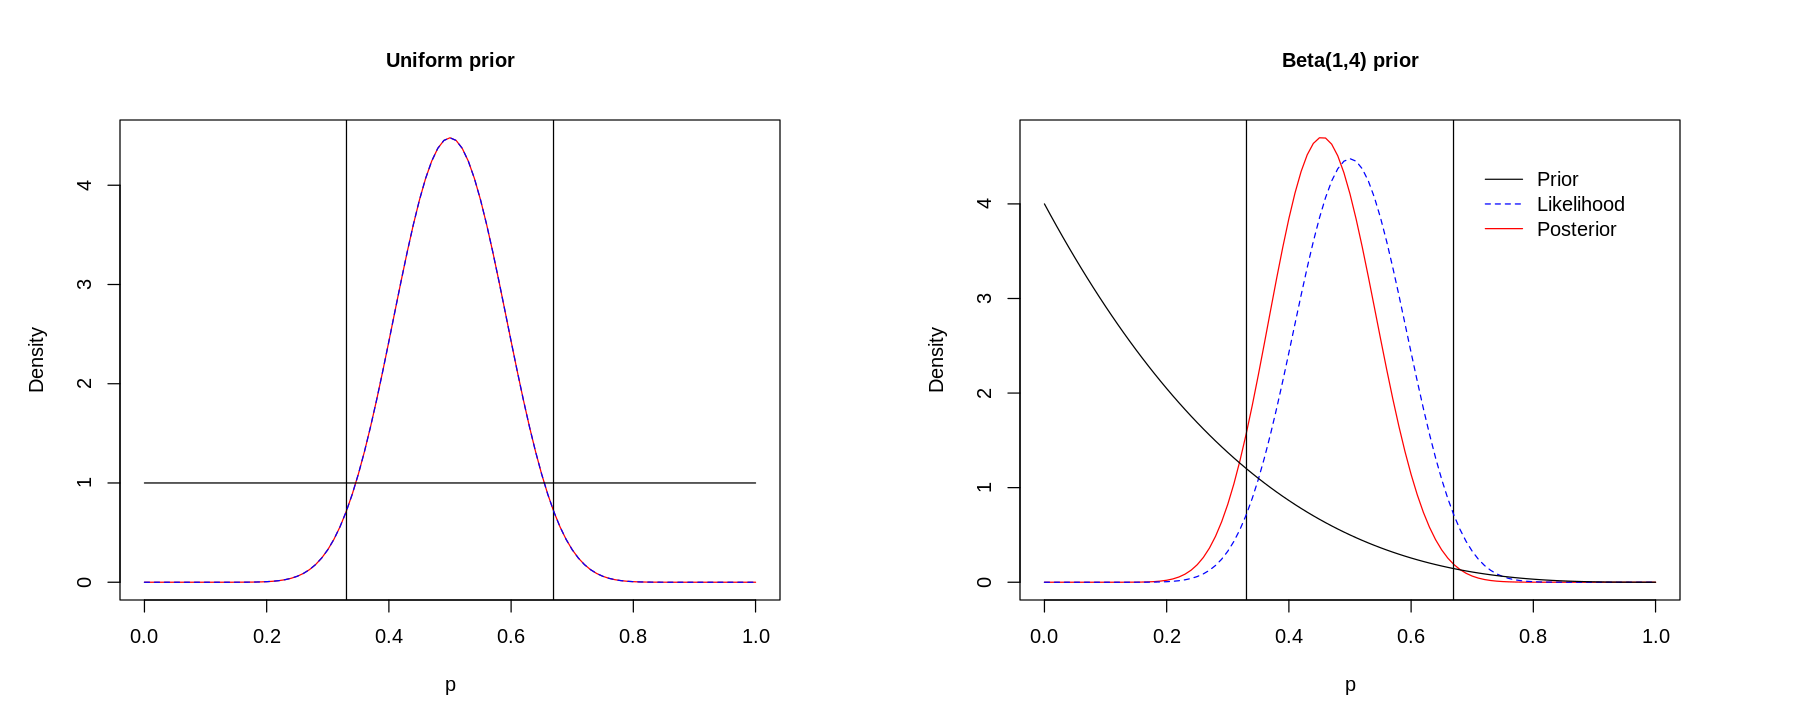

In [10]:
argmax <- c()
argmax <- append(argmax, optimise(function(x) dpost(unif)(x,y,n), interval = c(0, 1), maximum = TRUE)$maximum)
argmax <- append(argmax, optimise(function(x) dpost(beta14)(x,y,n), interval = c(0, 1), maximum = TRUE)$maximum)

# (2) compute the sigmas
sig <- c()
sig <- append(sig, sigma(y,n,1,1))
sig <- append(sig, sigma(y,n,1,4))
                           
# compute the credibility intervals
cred.limits <- c(0.025, 0.975)
crint <- c()
crint <- append(crint, qpost(unif)(cred.limits,y,n))
crint <- append(crint, qpost(beta14)(cred.limits,y,n))
                                    
# summarise the results in a dataframe
results <- data.frame(Prior = c('Uniform', 'Beta(1,4)'),
                     Argmax  = argmax,
                     CredibilityLimitInf = crint[c(1,3)],
                     CredibilityLimitSup = crint[c(2,4)])
                                 
par(mfrow = c(1, 2), cex.main = 1, cex.lab = 1, cex.axis = 1, mar = c(5, 5, 5, 5))
curve(dpost(unif)(x, y, n), from = 0, to = 1, col = "red", main = "Uniform prior", xlab = "p", ylab = "Density")
abline(v=crint[1])
abline(v=crint[2])               
curve(likelihood(x, y, n), from = 0, to = 1, col = "blue", lty=2, add=T)
curve(unif(x), from = 0, to = 1, add=T)

curve(dpost(beta14)(x, y, n), from = 0, to = 1, col = "red", main = "Beta(1,4) prior", xlab = "p", ylab = "Density")
abline(v=crint[1])
abline(v=crint[2])               
curve(likelihood(x, y, n), from = 0, to = 1, col = "blue", lty=2, add=T)
curve(beta14(x), from = 0, to = 1, add=T)
                                 
#legend("topright", legend = c("Prior", "Likelihood", "Posterior"), col = c("black", "blue", "red"), lty = c(1,2,1))
                                 
legend(0.6, 4.5,   # Position
       legend = c("Prior", "Likelihood", "Posterior"), # Vector with the name of each group
       col = c("black", "blue", "red"),                # Color of lines or symbols
       lty = c(1,2,1),                                 # Line type and width
       bty = "n",                                      # Box type (bty = "n" removes the box)
       cex = 1,                                        # Legend size
       seg.len = 0.5,                                  # Length of legend's segments
       x.intersp = 0.2, y.intersp = 1.2                # Distance between segments and labels and between labels
)
                                 
results

c) Repeat the same analysis assuming a sequential analysis of the data. Show how the most probable
value and the credibility interval change as a function of the number of coin tosses (i.e. from 1 to
30).

In [11]:
# Here we have the same functions as before, modified for the new problem 

beta_ab = function(p, alpha, beta){dbeta(p, alpha, beta)}

# Define the likelihood function               
likelihood_s = function(y, n, p){
    norm <- sum(dbinom(y, n, p))
    return (dbinom(y, n, p) / norm)
}
 

dpost_s = function(prior){ function(p, y, n){
    # normalise
    norm <- sum(likelihood_s(y, n, p) * prior)
    return(likelihood_s(y, n, p) * prior / norm) 
}}


qpost_s = function(prior){function(quant){

    # find the smaller i s.t. cumsum(prior)[i] < u
    values <- c()
    for (q in 1:length(quant)){
        i <- 1
        while (cumsum(prior)[[i]] < quant[q]) {i <- i + 1}
        values <- append(values, i)
    }
    return(values)
}}

In [12]:
argmax_u <- c()
argmax_b <- c()
cred.limits <- c(0.025, 0.975)
crint_u <- c()
crint_b <- c()

# Fix the spacing of the [0,1] vector p 
sp <- 500
dp <- 1/(sp-1)
p <- seq(0, 1, by = dp)

post_u <- matrix(nrow = 1, ncol = sp)
post_b <- matrix(nrow = 1, ncol = sp)

# Fix values for beta prior parameters
alpha <- 1
beta <- 100 

for (i in 1:30) {
    if (i == 1) {
        if (coin_toss[[i]] == 'T') {y <- 1}
        n <- 1
        u <- unif(p)
        b <- beta_ab(p, alpha, beta)
        
        # Calculate posterior with uniform and beta prior respectively
        post_u[1, ] <- dpost_s(u)(p, y, n)
        post_b[1, ] <- dpost_s(b)(p, y, n)
        
        argmax_u <- append(argmax_u, (which.max(post_u[i,])-1)*dp)
        argmax_b <- append(argmax_b, (which.max(post_b[i,])-1)*dp)
        # Compute the credibility intervals
        crint_u <- append(crint_u, qpost_s(post_u[1, ])(cred.limits))
        crint_b <- append(crint_b, qpost_s(post_b[1, ])(cred.limits))
    }
    else {
        if (coin_toss[[i]] == 'T') {y <- y+1}
        n <- i
        
        # Calculate posterior with the last posterior as prior
        post_u <- rbind(post_u, dpost_s(post_u[i-1, ])(p, y, n))
        post_b <- rbind(post_b, dpost_s(post_b[i-1, ])(p, y, n))
        
        argmax_u <- append(argmax_u, (which.max(post_u[i,])-1)*dp)
        argmax_b <- append(argmax_b, (which.max(post_b[i,])-1)*dp)
        # Compute the credibility intervals
        crint_u <- append(crint_u, qpost_s(post_u[i, ])(cred.limits))
        crint_b <- append(crint_b, qpost_s(post_b[i, ])(cred.limits))
}}

# Rescale to obtain the [0,1] value 
crint_u <- (crint_u-1)*dp
crint_b <- (crint_b-1)*dp

d) Do you get a different result, by analyzing the data sequentially with respect to a one-step analysis
(i.e. considering all the data as a whole) ?

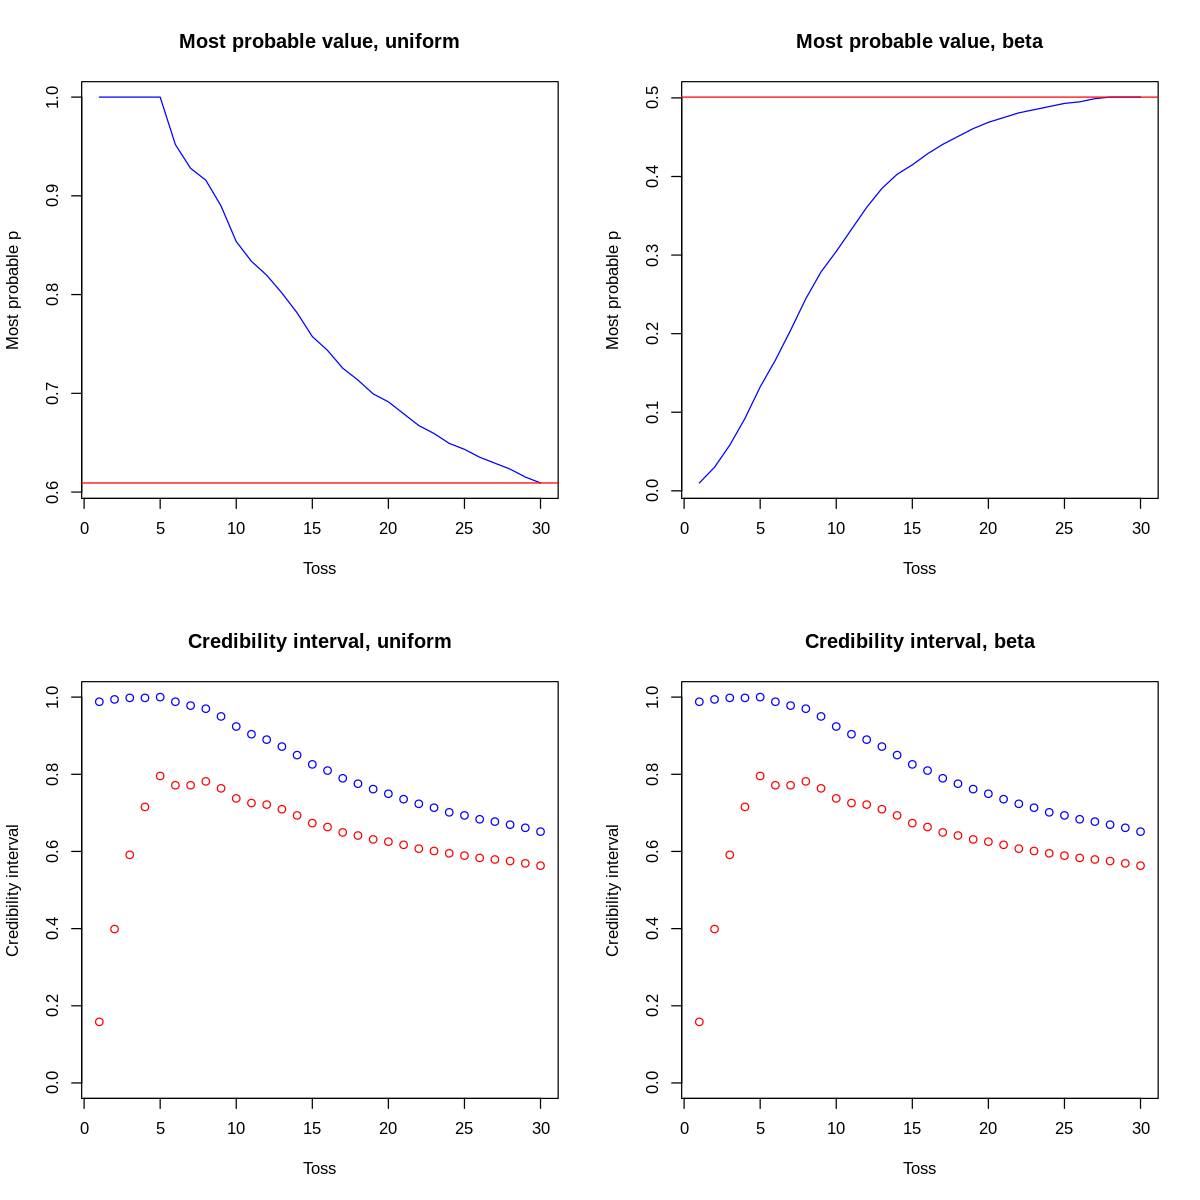

In [13]:
y_1 <- crint_u[seq(2, 60, 2)]
y_2 <- crint_u[seq(1, 60, 2)]
y_3 <- crint_b[seq(2, 60, 2)]
y_4 <- crint_b[seq(1, 60, 2)]
x <- rep(1:30, each = 1)

options(repr.plot.width=10, repr.plot.height=10)
par(mfrow = c(2, 2)) 

plot(argmax_u, type = "l", main = "Most probable value, uniform", xlab="Toss", ylab="Most probable p", col="blue")
abline(h = argmax_u[[n]], col = "red")
plot(argmax_b, type = "l", main = "Most probable value, beta", xlab="Toss", ylab="Most probable p", col="blue")
abline(h = argmax_b[[n]], col = "red")
plot(x, y_1, type = "p", main = "Credibility interval, uniform", xlab="Toss", ylab="Credibility interval", col="blue", ylim=c(0,1)) 
points(x, y_2, col="red", type="p")
plot(x, y_1, type = "p", main = "Credibility interval, beta", xlab="Toss", ylab="Credibility interval", col="blue", ylim=c(0,1)) 
points(x, y_2, col="red", type="p")

In [14]:
# Summarise the results in a dataframe
seq_res <- data.frame(Prior = c('Uniform', 'Beta(1,4)'),
                     Argmax  = c(argmax_u[[n]], argmax_b[[n]]),
                     CredibilityLimitInf = c(y_2[[n]], y_4[[n]]),
                     CredibilityLimitSup = c(y_1[[n]],y_3[[n]])
)            
cat("These are the results of the one-step analysis \n ")
results
cat("\n These are the results of the sequential analysis \n \n ")
seq_res

These are the results of the one-step analysis 
 

Prior,Argmax,CredibilityLimitInf,CredibilityLimitSup
<chr>,<dbl>,<dbl>,<dbl>
Uniform,0.5000000,0.3306054,0.6693946
"Beta(1,4)",0.4545449,0.2978125,0.6211433



 These are the results of the sequential analysis 
 
 

Prior,Argmax,CredibilityLimitInf,CredibilityLimitSup
<chr>,<dbl>,<dbl>,<dbl>
Uniform,0.6092184,0.5631263,0.6513026
"Beta(1,4)",0.5010020,0.4609218,0.5430862


## Exercise 4 - Six Boxes Toy Model : inference

• Labeling the boxes as follows:

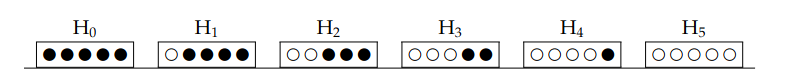

• Write a program in R that performs a simulation of the process
1) after selecting a random box
2) make random sampling from the box
3) prins on the standard output the probability of selecting each box
4) plot the probability for each box as a function of the number of trial

In [15]:
#Define content of boxes: 0 for black, 1 for white
boxes <-  function(j){ 
  a <- rep(0, 5)
  # Replace the first j elements with 1s
  if (j != 0) {a[1:j] <- 1}
  # Return the resulting vector
  return(a)
}

# Posterior probability density function 
dpost = function(prior, draw){
    
    # The likhelihood depends on the color of the draw at the n-th time 
    if (draw == 1) {likelihood <- c(0, 1/5, 2/5, 3/5, 4/5, 1)}
    else {likelihood <- c(1, 4/5, 3/5, 2/5, 1/5, 0)}
    norm_f <- sum(likelihood*prior)
    posterior <- c()
    
    posterior <- (likelihood* prior)/ norm_f
    
    return(posterior)
}


In [16]:
# Select random box 

set.seed(Sys.time())
n_boxes <- 6
j <- sample(1:n_boxes-1, 1)

# "Construct" the content of our box 

box <- boxes(j)
cat("j = ",j,  "  Box content", box)

trials <- 40

j =  2   Box content 1 1 0 0 0

In [17]:
# Draw for "trials" times the ball from the box (without replacement)
draws <- sample(box, trials, replace = TRUE)
draws

[1] 1 1 1 1 1 0 0 1 1 0 0 1 1 1 0 0 0 0 1 0 0 1 1 1 0 0 1 1 1 0 0 1 1 0 0 0 1 1
[39] 0 0

In [18]:
# Define the matrix that will store the posterior as a function of the number of the trial

prior <- matrix(nrow = 1, ncol = 6)

for (trial in 1:trials) {
    
    # first trial, equal probabilities 
    if (trial == 1) {prior[1, ] <- rep(1/n_boxes , n_boxes)}
    
    # new prior = old posterior
    else {prior <- rbind(prior, dpost(prior[trial-1, ], draws[[trial]]))}
}

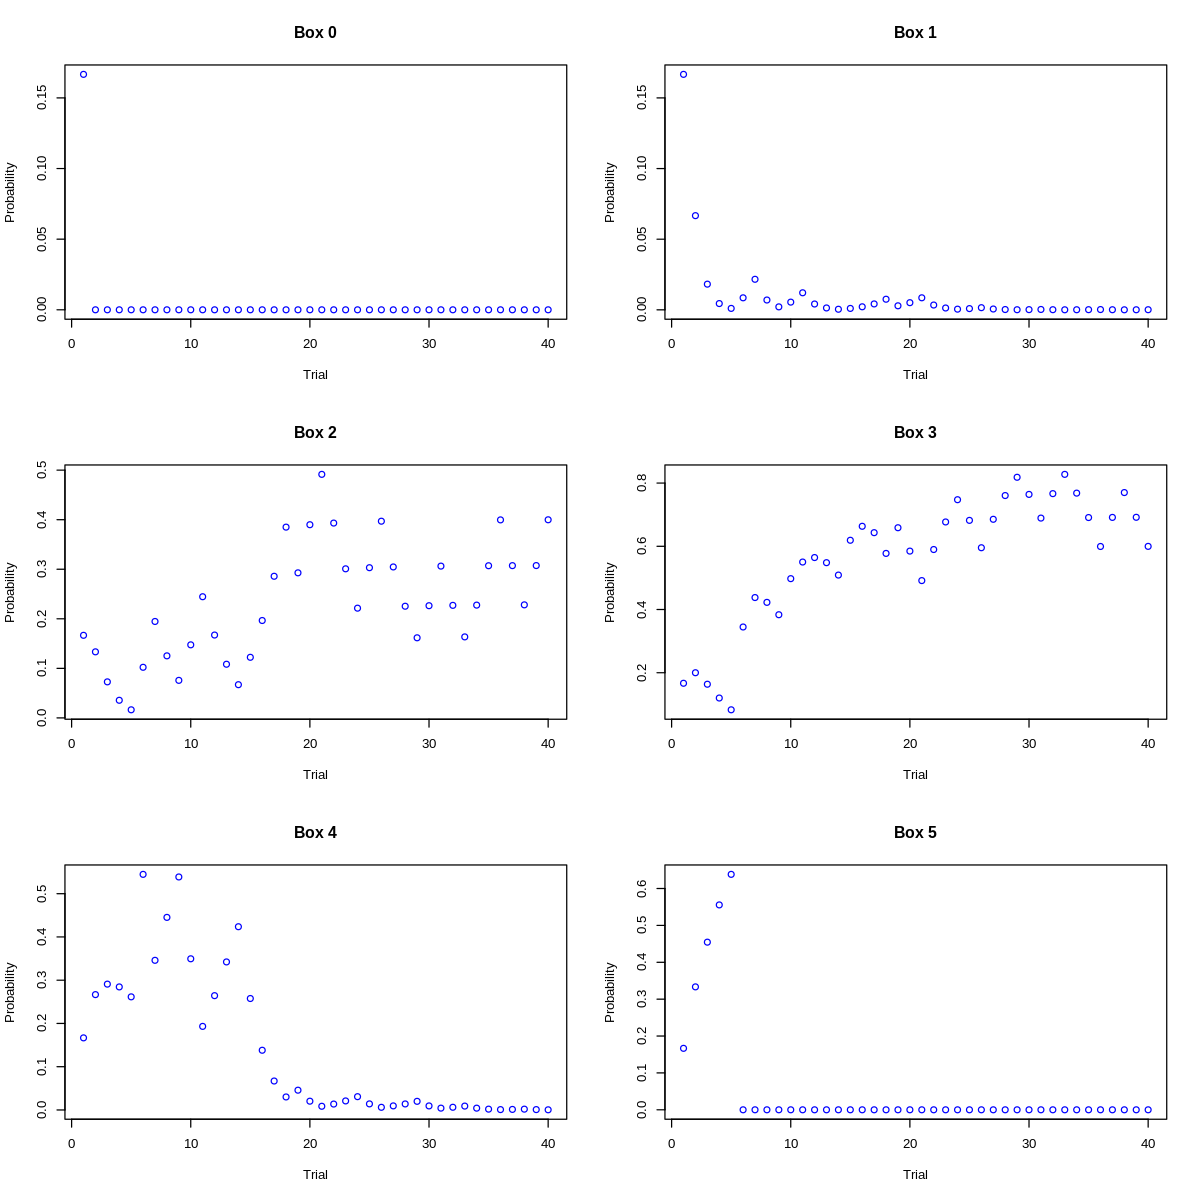

In [19]:
options(repr.plot.width=10, repr.plot.height=10)
par(mfrow = c(3, 2)) 
for (i in 1:ncol(prior)) {
  plot(prior[, i], type = "p", main = paste("Box", i-1), xlab="Trial", ylab="Probability", col="blue")
}